In [1]:
import sys
sys.path.append('../..')
import multicomp as mm
import numpy as np

# Generate Combinations(Calvin)

In [2]:
import numpy as np

def generate_combinations_2(num_components, step_size):
    
    combinations = []

    
    def generate(current, remaining, depth):
        if depth == num_components - 1:
            combinations.append(current + [remaining])
            return
        for i in np.arange(0, remaining + step_size, step_size):
            generate(current + [i], remaining - i, depth + 1)

    generate([], 1.0, 0)
    return np.array(combinations)


def replace_negative(matrix,small_val):
    # Replace negative values in the matrix with 0.01
    modified_matrix = np.where(matrix < 0, small_val, matrix)
    return modified_matrix




def thresh(arr, threshold):
    # Create a boolean mask where True indicates that all elements in the row are above the threshold
    mask = np.all(arr >= threshold, axis=1)

    # Use the mask to select rows that meet the condition
    return arr[mask]


In [3]:

#Generate combinations with (num_comp, step_size)
#Threshold function, gets rid of all rows with values less than threshold

combinations = generate_combinations_2(3,0.1)
combinations = thresh(combinations,0.1)
print(combinations)


#combinations = np.array([row for row in combinations if 0 not in row])
#combinations -= 0.01
#combinations = replace_negative(combinations,0.01)
#print(combinations)


[[0.1 0.1 0.8]
 [0.1 0.2 0.7]
 [0.1 0.3 0.6]
 [0.1 0.4 0.5]
 [0.1 0.5 0.4]
 [0.1 0.6 0.3]
 [0.1 0.7 0.2]
 [0.2 0.1 0.7]
 [0.2 0.2 0.6]
 [0.2 0.3 0.5]
 [0.2 0.4 0.4]
 [0.2 0.5 0.3]
 [0.2 0.6 0.2]
 [0.3 0.1 0.6]
 [0.3 0.2 0.5]
 [0.3 0.3 0.4]
 [0.3 0.4 0.3]
 [0.3 0.5 0.2]
 [0.4 0.1 0.5]
 [0.4 0.2 0.4]
 [0.4 0.3 0.3]
 [0.4 0.4 0.2]
 [0.5 0.1 0.4]
 [0.5 0.2 0.3]
 [0.5 0.3 0.2]
 [0.6 0.1 0.3]
 [0.6 0.2 0.2]
 [0.7 0.1 0.2]]


# Obtain coexisting phases for an arbitrary interaction matrix and average compositions
Note: package assumes the existence of an inert solvent, determined by the incompressibility condition.

## system settings

In [4]:
# an arbitrary symmetric matrix of 4 components + 1 inert solvent.
# The interaction between components and the solvent is assume to be zero.
# Note that the diagonal elements are not necessary to be zero.
# With non-zero diagonal elements, the system will be effective interactions between solvent and other components.
'''chi_matrix = [
    [0.0, 4.0, 5.0, 6.0],
    [4.0, 0.0, 7.0, 6.0],
    [5.0, 7.0, 0.0, 3.0],
    [6.0, 6.0, 3.0, 0.0],
]'''


chi_matrix = np.array([[0, 2.7, 2.8], [0, 0, 2.9], [0, 0, 0]])
chi_matrix = chi_matrix + chi_matrix.T

# average compositions of the entire system
# the volume fraction of the solvent is determined by incompressibility
phi_vector = [0.33, 0.33, 0.33]

## Create some compartments

In [5]:
# number of phases that the system will generate
num_compartments = 64 # a overkill but safe choice for 4+1 components
# create the Flory-Huggins free energy
fh_energy = mm.FloryHuggins(np.array(chi_matrix))
# generate a collection of compartments
# we generate compartments that all of them share the same composition, namely the average composition, here.
# the FieldLikeRelaxationDynamics afterwards will add fluctuations to the compositions itself.


phis = [phi_vector] * num_compartments
mixture = mm.MultiphaseVolumeSystem(
    fh_energy, 
    np.array(phis), # compositions of each compartment
    np.ones(num_compartments) / num_compartments # relative volume of each compartment
)

## Hyperparameters 

In [6]:
dynamics_params = {
    "initialization_random_std": 5,  # how random the initial guess is
    "acceptance_Js": 0.0002, # how fast the relative volumes are evolved
    "acceptance_omega": 0.002, # how fast the compositions are evolved
}

evolve_params = {
    "t_range": 1000000,  # maximum iteration steps
    "dt": 1,  # always unity for FieldLikeRelaxationDynamics
    "interval": 10000,  # the frequency for checking convergence
    "tolerance": 1e-5,  # criteria for determining convergence
    "progress": True,
    "save_intermediate_data": False,
}

## Create the dynamics and find the coexisting states

In [7]:
dynamics = mm.FieldLikeRelaxationDynamics(mixture, parameters=dynamics_params)
ts, result = dynamics.evolve(**evolve_params)

## Print and Check

In [8]:
unique_phases = result.get_clusters()
print(len(unique_phases), "phases are found")
print("Compositions are ")
print(unique_phases)
print("Convergence is (lower the better) ")
print(result.entropy_production)



3 phases are found
Compositions are 
[[0.1424392  0.13023922 0.71840182]
 [0.18312692 0.65530354 0.15188124]
 [0.54555077 0.23366222 0.20990698]]
Convergence is (lower the better) 
0.000546516010250633


# Test Functions

In [9]:
def get_no_of_phases(phi_vector,fh_energy):
    dynamics_params = {
    "initialization_random_std": 5,  # how random the initial guess is
    "acceptance_Js": 0.0002, # how fast the relative volumes are evolved
    "acceptance_omega": 0.002, # how fast the compositions are evolved
    }

    evolve_params = {
    "t_range": 1000000,  # maximum iteration steps
    "dt": 1,  # always unity for FieldLikeRelaxationDynamics
    "interval": 10000,  # the frequency for checking convergence
    "tolerance": 1e-5,  # criteria for determining convergence
    "progress": True,
    "save_intermediate_data": False,
    }
    num_compartments = 64
    phis = [phi_vector] * num_compartments
    mixture = mm.MultiphaseVolumeSystem(
        fh_energy, 
        np.array(phis), # compositions of each compartment
        np.ones(num_compartments) / num_compartments # relative volume of each compartment
    )    
    
    dynamics = mm.FieldLikeRelaxationDynamics(mixture, parameters=dynamics_params)
    ts, result = dynamics.evolve(**evolve_params)
    unique_phases = result.get_clusters()
    return len(unique_phases)
    
    


In [10]:
get_no_of_phases(phi_vector,fh_energy)


3

In [11]:
from tqdm.notebook import tqdm
print("start")
'''
combinations = generate_combinations_2(3,0.1)
combinations = np.array([row for row in combinations if 0 not in row])

combinations -= 0.01
combinations = replace_negative(combinations,0.01)
'''
ternary_matrix = np.empty((combinations.shape[0], 2), dtype=object)
#print(combinations)

print("Init ternary_matrix")


for i, row in enumerate(tqdm(combinations)):
    print("row " + str(i))
    ternary_matrix[i, 0] = row
   
    # Apply the arbitrary function to the row and add the result to the second column
    fh_energy = mm.FloryHuggins(np.array(chi_matrix))
    ternary_matrix[i, 1] = get_no_of_phases(row,fh_energy)
    print(ternary_matrix[i,1])

    


start
Init ternary_matrix


row 0



1
row 1



2
row 2



2
row 3



2
row 4



2
row 5



2
row 6



2
row 7



2
row 8



3
row 9



3
row 10



3
row 11



3
row 12



3
row 13



2
row 14



3
row 15



3
row 16



3
row 17



3
row 18



2
row 19



3
row 20



3
row 21



3
row 22


KeyboardInterrupt: 

# Plot Ternary Diagram

In [ ]:
import matplotlib.pyplot as plt
import mpltern  # Import the mpltern package for ternary plots
def plot_ternary(data):

    ternary_components = np.array([item[0].flatten() for item in data])
    values = np.array([item[1] for item in data])

    # Create ternary plot
    fig, tax = plt.subplots(subplot_kw=dict(projection='ternary'))

    # Scatter plot where color depends on the value
    sc = tax.scatter(ternary_components[:, 0], ternary_components[:, 1], ternary_components[:, 2], c=values, cmap='viridis')

    # Add color bar
    plt.colorbar(sc, label='Value')

    # Setting labels for ternary axes
    tax.set_tlabel("Component 1")
    tax.set_llabel("Component 2")
    tax.set_rlabel("Component 3")

    # Set title and other plot labels if necessary
    plt.title("Ternary Phase Diagram")

    plt.show()




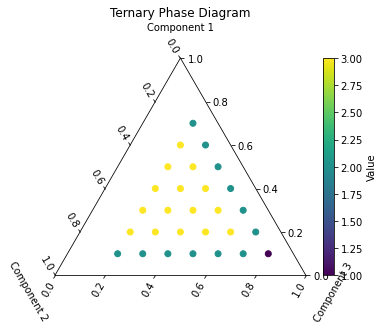

[[array([0.1, 0.1, 0.8]) 1]
 [array([0.1, 0.2, 0.7]) 2]
 [array([0.1, 0.3, 0.6]) 2]
 [array([0.1, 0.4, 0.5]) 2]
 [array([0.1, 0.5, 0.4]) 2]
 [array([0.1, 0.6, 0.3]) 2]
 [array([0.1, 0.7, 0.2]) 2]
 [array([0.2, 0.1, 0.7]) 2]
 [array([0.2, 0.2, 0.6]) 3]
 [array([0.2, 0.3, 0.5]) 3]
 [array([0.2, 0.4, 0.4]) 3]
 [array([0.2, 0.5, 0.3]) 3]
 [array([0.2, 0.6, 0.2]) 3]
 [array([0.3, 0.1, 0.6]) 2]
 [array([0.3, 0.2, 0.5]) 3]
 [array([0.3, 0.3, 0.4]) 3]
 [array([0.3, 0.4, 0.3]) 3]
 [array([0.3, 0.5, 0.2]) 3]
 [array([0.4, 0.1, 0.5]) 2]
 [array([0.4, 0.2, 0.4]) 3]
 [array([0.4, 0.3, 0.3]) 3]
 [array([0.4, 0.4, 0.2]) 3]
 [array([0.5, 0.1, 0.4]) 2]
 [array([0.5, 0.2, 0.3]) 3]
 [array([0.5, 0.3, 0.2]) 3]
 [array([0.6, 0.1, 0.3]) 2]
 [array([0.6, 0.2, 0.2]) 3]
 [array([0.7, 0.1, 0.2]) 2]]


In [207]:
plot_ternary(ternary_matrix)
print(ternary_matrix)

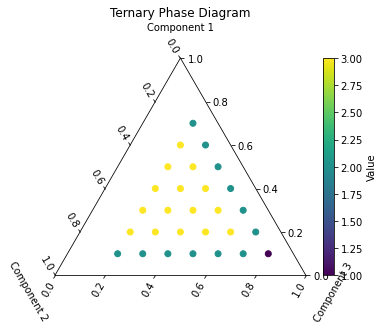